In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import numpy as np
import os

import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


sns.set()
sns.color_palette("bright")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cpu


In [3]:
seed = 42 
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_trainset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

batch_size = 100

num_train = len(full_trainset)
num_valid = int(0.1 * num_train)
num_train -= num_valid

trainset, validset = random_split(full_trainset, [num_train, num_valid])

# Create the DataLoader for training and validation sets
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=2)

# Download and load the test dataset
testset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes in CIFAR-10
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


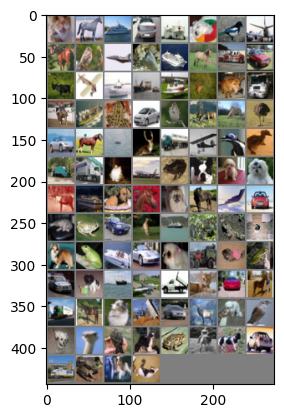

cat   horse ship  car   ship  dog   bird  plane horse bird  plane bird  ship  horse truck car   deer  plane ship  ship  plane deer  dog   truck horse ship  frog  car   bird  deer  dog   bird  car   horse ship  deer  truck plane bird  bird  truck truck cat   plane frog  dog   dog   dog   deer  ship  dog   horse dog   horse plane car   cat   frog  car   deer  ship  frog  frog  cat   dog   frog  ship  car   dog   truck dog   frog  car   dog   ship  plane truck cat   car   horse truck horse dog   truck car   deer  dog   bird  dog   bird  bird  dog   frog  horse dog   car   truck frog  dog   cat  


In [5]:
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from model import BaselineModel

net = BaselineModel(num_channels=3)
net.to(device)

BaselineModel(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
num_epochs = 10
training_losses = []
validation_losses = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    net.train()
    training_loss = 0.0
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
    training_loss /= len(trainloader)
    training_losses.append(training_loss)

    # Validation
    net.eval()
    validation_loss = 0
    with torch.no_grad(): 
        for (inputs, labels) in validloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
    
    validation_loss /= len(validloader)
    validation_losses.append(validation_loss)
    
    print(f"Epoch: {epoch+1}, training_loss: {training_loss}, validation_loss: {validation_loss}")    

Epoch: 1, training_loss: 2.301168682840135, validation_loss: 2.296576828956604
Epoch: 2, training_loss: 2.2741750351587933, validation_loss: 2.217256255149841
Epoch: 3, training_loss: 2.0962770766682093, validation_loss: 2.029510235786438
Epoch: 4, training_loss: 1.970084352493286, validation_loss: 1.9382339906692505
Epoch: 5, training_loss: 1.8927804896566602, validation_loss: 1.8688196682929992
Epoch: 6, training_loss: 1.813383875687917, validation_loss: 1.782710506916046
Epoch: 7, training_loss: 1.716008783446418, validation_loss: 1.6681371903419495
Epoch: 8, training_loss: 1.622012302875519, validation_loss: 1.6112063884735108
Epoch: 9, training_loss: 1.5657192574607002, validation_loss: 1.5654431676864624
Epoch: 10, training_loss: 1.5233586830563015, validation_loss: 1.5303527426719665


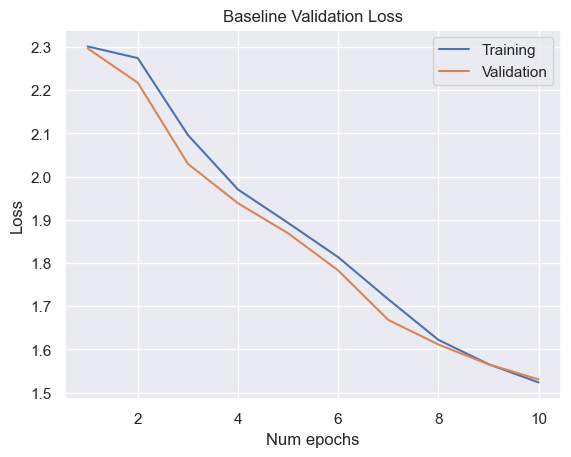

In [18]:
x = np.linspace(1, len(training_losses), len(training_losses))
plt.plot(x, training_losses, label="Training")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Baseline Training Loss")

plt.plot(x, validation_losses, label="Validation")
plt.xlabel("Num epochs")
plt.ylabel("Loss")
plt.title("Baseline Validation Loss")
plt.legend()

plt.show()

In [19]:
# Save the model
model_path = './models/baseline.pth'
if not os.path.exists("models"): 
  os.makedirs("models")
torch.save(net.state_dict(), model_path)

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 46 %
